# Importação de Bibliotecas

In [2]:
from statistics import median

import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import shapiro, boxcox, probplot, norm
from arch import arch_model

import mplfinance as fplt

A ação escolhida é da AMBEV, porém outras podem ser analisadas ao escolher o código da ação desejada. No caso o da AMBEV é a ABEV3.SA

In [3]:
acao_ambev = yf.Ticker("ABEV3.SA")

É definido um conjunto de teste e outro de treino, onde as datas para treino serão após o início da pandemia (primeiro de abril) com término no começo de 2022, e a data de teste após essa data até o início do mês de julho.

In [4]:
data_ambev = acao_ambev.history(start="2020-04-01", end="2022-04-01", interval="1wk")

data_ambev.reset_index(level=0, inplace=True)

# Exploração dos Dados

In [5]:
data_ambev

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-03-30,10.825117,11.422364,10.414508,10.629145,66092600.0,0.0,0
1,2020-04-06,11.198395,12.103599,10.899772,11.291716,103344500.0,0.0,0
2,2020-04-13,11.301047,11.748984,10.638476,10.825116,116952300.0,0.0,0
3,2020-04-20,10.638475,11.058416,9.966572,10.367847,119386000.0,0.0,0
4,2020-04-27,10.591816,11.366371,10.498495,10.582483,116581200.0,0.0,0
...,...,...,...,...,...,...,...,...
103,2022-02-28,15.200000,15.200000,13.820000,13.930000,101573100.0,0.0,0
104,2022-03-07,13.790000,14.000000,13.060000,13.180000,172693400.0,0.0,0
105,2022-03-14,13.220000,14.250000,13.160000,14.250000,149107600.0,0.0,0
106,2022-03-21,14.060000,14.500000,13.950000,14.320000,115895000.0,0.0,0


In [6]:
data_ambev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          108 non-null    datetime64[ns]
 1   Open          105 non-null    float64       
 2   High          105 non-null    float64       
 3   Low           105 non-null    float64       
 4   Close         105 non-null    float64       
 5   Volume        105 non-null    float64       
 6   Dividends     108 non-null    float64       
 7   Stock Splits  108 non-null    int64         
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 6.9 KB


In [7]:
data_ambev.isna().sum()

Date            0
Open            3
High            3
Low             3
Close           3
Volume          3
Dividends       0
Stock Splits    0
dtype: int64

<AxesSubplot:xlabel='Date', ylabel='Open'>

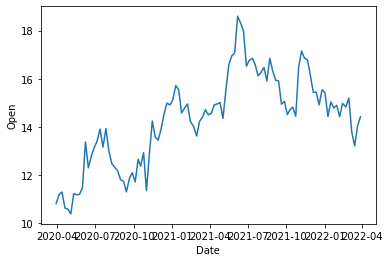

In [8]:
data_ambev.dropna(inplace=True)

sns.lineplot(data=data_ambev, x="Date", y="Open")

## Decomposição

Toda série temporal pode ser decomposta em 3 partes: tendência, sazonalidade e resíduo, que é o que resta após retirar da série as duas primeiras partes, abaixo a separação dessas partes:

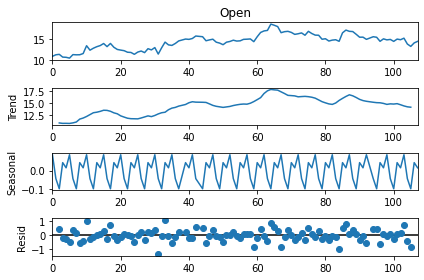

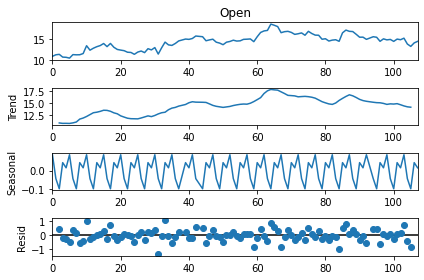

In [9]:
decompose_result_mult = seasonal_decompose(data_ambev["Open"], model="additive", period=5)

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot()

Claramente a série tem uma tendência de alta, além de apresentar uma sazonalidade.

## Teste Dickey Fuller

Primeiramente vamos usar o teste de Dickey Fuller, usarei o valor P base de 5%, ou seja, caso o valor P esteja abaixo desses 5% significa que a série é estatisticamente estacionária e podemos rejeitar a hipótese nula de que ela não seja, e caso for acima não podemos rejeitar ela.

In [10]:
X = data_ambev["Open"].values

result = adfuller(X)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.311972
p-value: 0.168136
Critical Values:
	1%: -3.495
	5%: -2.890
	10%: -2.582


Neste caso o teste de Dickey Fuller indicou que a série não é estacionária (Valor P de 16% e os valores críticos de 1%, 5% e 10% são menores que o teste estatístico), aceitamos a hipótese nula por enquanto.

## Diferenciação

A função de diferenciação é criada, onde ela vai  remover os sinais de tendências e reduzir a variância, ela simplesmente é a diferença do valor do período T com o valor do período anterior T-1.

In [11]:
def difference(dataset, interval=1):

	diff = list()

	for i in range(interval, len(dataset)):
		
		value = dataset[i] - dataset[i - interval]
		diff.append(value)

	return pd.Series(diff)

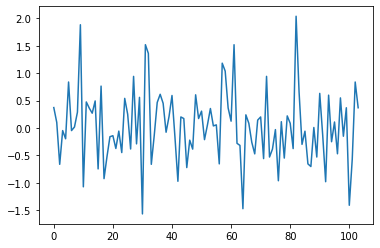

In [12]:
X = data_ambev["Open"].values
data_diferenciada = difference(X)
plt.plot(data_diferenciada)
plt.show()

Com a diferenciação realizada podemos ver no gráfico acima como a série está estabilizada e já pode ser considerada estacionária, mas confirmamos com o teste novamente de ADF.

### Confirmação com ADFuller

In [13]:
result = adfuller(data_diferenciada)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
	
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.553430
p-value: 0.000000
Critical Values:
	1%: -3.495
	5%: -2.890
	10%: -2.582


Neste caso confirmamos que a série está estácionária, o valor P está zerado e se formos comparar, o valor do teste estatístico está muito abaixo dos valores críticos.

Normalmente só é necessário uma diferenciação para transformar uma série em estacionária, mas caso seja necessário, pode-se aplicar uma segunda diferenciação, neste caso a diferenciação será sobre a primeira diferenciação (dificilmente haverá casos com mais do que 2 diferenciações).

Abaixo vamos realizar o teste de normalidade por meio do Saphiro-Wilk, que avalia uma amostra de dados e quantifica a probabilidade de os dados terem sido extraídos de uma distribuição gaussiana (distribuição normal).

## Saphiro-Wilk

In [14]:
shapiro(data_diferenciada)

ShapiroResult(statistic=0.982894778251648, pvalue=0.2003680020570755)

Como o teste estatístico deu 0.98 e seu p-value correspondende 0.20, como o p-value é maior que 0.05, então temos certeza que podemos rejeitar a hipótese nula de que os dados não vem de uma distribuição normal.

Caso o resultado obtido para o valor p fosse abaixo de 0.05, teríamos que utilizar outro método para manter uma distribuição normal. Para resolver isso utilizamos por exemplo a transformação Box-Cox, onde busca-se o melhor valor de lambda que transforme a série para que fique com uma distribuição mais próxima de uma distribuição normal gaussiana, porém como é necessário que o Box-Cox contenha apenas valores positivos, precisamos primeiro normalizar esses valores.

## Transformação Box-Cox

In [15]:
scaler = MinMaxScaler(feature_range=(0.001, 10))
normalizados = scaler.fit_transform([[x] for x in data_diferenciada])

In [16]:
normalizados = normalizados.ravel()

Text(0.5, 1.0, 'Probplot sem distruibuição normal')

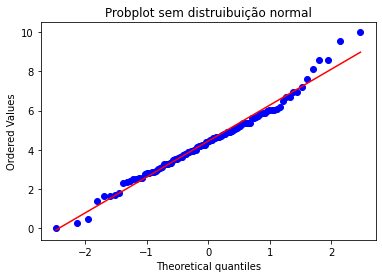

In [17]:
fig = plt.figure()
ax1 = fig.add_subplot()
prob = probplot(normalizados, dist=norm, plot=ax1)
ax1.set_title('Probplot sem distruibuição normal')

Text(0.5, 1.0, 'Probplot depois da transformação de Box-Cox')

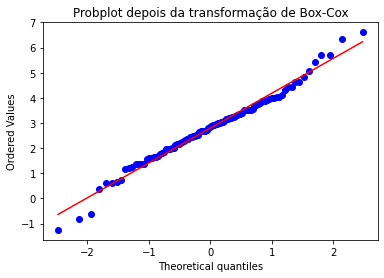

In [18]:
fig = plt.figure()
ax2 = fig.add_subplot()
teste_boxcox, _ = boxcox(normalizados)
prob = probplot(teste_boxcox, dist=norm, plot=ax2)
ax2.set_title('Probplot depois da transformação de Box-Cox')

In [19]:
data_normalizada = pd.Series(normalizados)

In [20]:
data_boxcox = pd.Series(teste_boxcox)

Ao realizar a transformação de Box-Cox é possível ver uma distribuição mais retilínea e esparsa de seus dados, atribuindo assim a distribuição normal dos dados.

Podemos realizar o teste de Shapiro novamente para verificar o seu valor p.

In [21]:
shapiro(data_boxcox)

ShapiroResult(statistic=0.9852392077445984, pvalue=0.30411556363105774)

Nesse caso o valor p aumentou para 30,4%, o que significa que seus dados estão mais distribuídos normalmente. Podemos manter esse resultado para as análises seguintes.

## Médias Móveis

É realizado inicialmente o estudo de médias móveis, onde suavizamos o ruído ou dados com lacunas através de uma projeção futura baseada no valor das janelas escolhidas. Essa janela rolante de um modelo de série temporal avalia:

* A estabilidade do modelo ao longo do tempo. Uma suposição comum do modelo de série temporal é que os coeficientes são constantes em relação ao tempo. Verificar a instabilidade equivale a examinar se os coeficientes são invariantes no tempo.

* A precisão da previsão do modelo.

O tamanho da janela de rolagem dependerá do tamanho da amostra e da periodicidade dos dados. Em geral, podemos usar um tamanho de janela rolante curto para dados coletados em intervalos curtos e um tamanho maior para dados coletados em intervalos mais longos. Tamanhos de janela de rolagem mais longos tendem a gerar estimativas de janela de rolagem mais suaves do que tamanhos mais curtos. Escolhemos o rolling com um período 48 (a cada 48 amostras uma janela avança para o dado seguinte enquanto o último dado é removido da análise), pois estamos analisando a cotação semanalmente.

<AxesSubplot:xlabel='Date'>

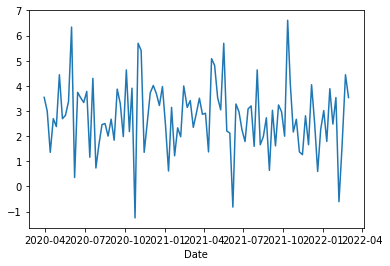

In [22]:
sns.lineplot(data=data_ambev, x="Date", y=data_boxcox)

<AxesSubplot:xlabel='Date'>

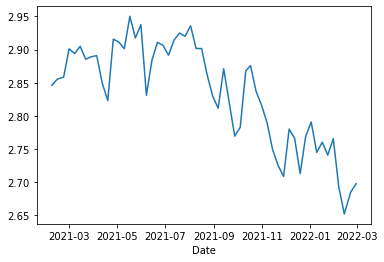

In [25]:
media_movel_open = data_boxcox.rolling(window=48).mean()

sns.lineplot(data=data_ambev, x="Date", y=media_movel_open)

Temos uma tendência decrescente ao realizar as médias móveis, confirmamos isso abaixo ao realizar a média dos valores dos dados e após isso retiramos a tendência da série para que possa ser estudada sem esse fator.

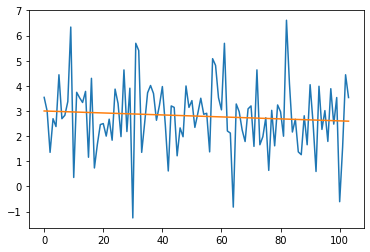

In [27]:
X = [i for i in range(0, len(data_boxcox))]
X = np.reshape(X, (len(X), 1))
y = data_boxcox.values
model = LinearRegression()
model.fit(X, y)

trend = model.predict(X)

plt.plot(y)
plt.plot(trend)
plt.show()

## Sazonalidade

Variações sazonais são oscilações de curto prazo, que ocorrem sempre dentro do ano, e que se repetem sistematicamente ano após ano. Uma série temporal registrada anualmente não tem componente sazonal.

Para que possamos obter a variação sazonal é recomendado que a série tenha no mínimo quatro anos, ou no caso de ser semanalmente, 48 semanas, pois para menores valores fica mais complicado para confirmar a existência da regularidade inerente às variações sazonais (alguns programas estatísticos simplesmente não apresentam os resultados para séries menores).

Através do Método da Média Móvel Percentual podemos obter os índices sazonais, suas etapas consistem em:

1) obter médias móveis de ordem igual ao número de períodos sazonais;

2) obter médias móveis de 2 períodos, centradas, a partir das médias móveis calculadas no passo 1;

3) obter os índices sazonais para cada período:
    - no modelo ADITIVO, subtraindo dos valores originais da série as médias móveis centradas calculadas no passo 2;
    
    - no modelo MULTIPLICATIVO, dividindo os valores originais da série pelas médias móveis centradas calculadas no passo 2;

4) obter medidas de síntese dos índices calculados no passo 3, que representarão cada período sazonal (por exemplo, a mediana dos índices sazonais de todos os janeiros existentes na série).
    - no modelo ADITIVO, calcular a média aritmética simples dos valores correspondentes ao período sazonal (média dos índices obtidos em todos os janeiros da série, por exemplo);
    
    - no modelo MULTIPLICATIVO, calcular a média aritmética simples dos valores correspondentes ao período sazonal, sem incluir os valores máximo e mínimo10 (imagine que há os índices 1,05; 1,054; 1,061; 1,07; 1,072; 1,08, a média seria calculada excluindo os valores 1,05 e 1,08, mínimo e máximo respectivamente); uma solução alternativa seria calcular a mediana dos índices de cada período.

5) fazer as correções necessárias para que a soma dos índices seja coerente (igual a zero para o aditivo e igual à ordem da sazonalidade no multiplicativo):
    - no modelo ADITIVO, somar todos os índices calculados no passo 4 e dividir a soma pela ordem da sazonalidade (4 se trimestral, 12 se mensal, etc.); o resultado deverá ser subtraído de cada um dos índices, garantindo que a soma deles seja igual a zero.

    - no modelo MULTIPLICATIVO, somar todos os índices calculados no passo 4, subtrair da soma a ordem da sazonalidade (4 se trimestral, 12 se mensal, etc.), e dividir a subtração pela ordem da sazonalidade (novamente, 4 se trimestral, 12 se mensal, etc.); subtrair o resultado de 1; o resultado deverá ser multiplicado por cada um dos índices, garantindo que a soma deles seja igual à ordem da sazonalidade. 

Conforme já obtido anteriormente, o valor das médias móveis será 48

## ACF e PACF

Para ter a previsibilidade, uma série com uma única variável deve ser auto correlacionada, ou seja, o período atual deve ter explicação com base em um período anterior (lag), porém essa característica de auto correlação é de uma série não estacionária. Como já realizamos a transformação para uma série estacionária então utilizaremos a auto correlação parcial, onde o efeito do lag anterior sobre o período atual é removido e só resta o efeito do lag analisado sobre o período atual, exemplo: a auto correlação parcial do quarto lag irá remover o efeito do primeiro, segundo e terceiro lag.

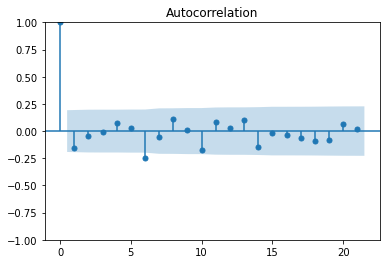

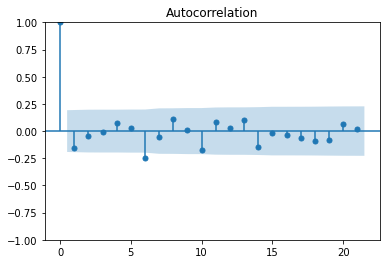

In [62]:
plot_acf(data_boxcox)

c:\Users\Mayara Lopes\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


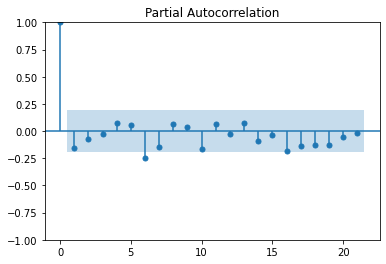

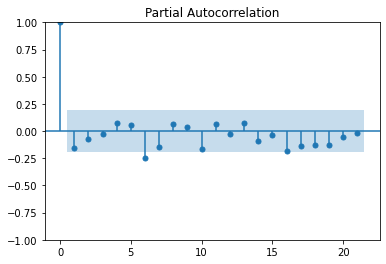

In [63]:
plot_pacf(data_boxcox)


O gráfico de auto correlação mostra que a série tem correlação significativa somente no primeiro lag da auto correlação, e um significativo no gráfico de auto correlação parcial.

# Criação, Treinamento e Validação

## ARCH

In [ ]:
garch_model = arch_model(dado_treino, p=25, q=1, vol='ARCH', dist='Normal')

resultados = garch_model.fit(disp='off')

print(resultados.summary())

In [ ]:
resultados_forecast = resultados.forecast(horizon=5)

print(resultados_forecast.variance[-1:])

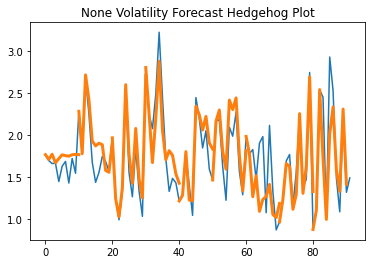

In [101]:
g_previsões = resultados.hedgehog_plot()


## ARIMA

In [72]:
dado_treino = data_normalizada[:92]
dado_teste = data_normalizada[92:]

c:\Users\Mayara Lopes\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Mayara Lopes\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:ylabel='predicted_mean'>

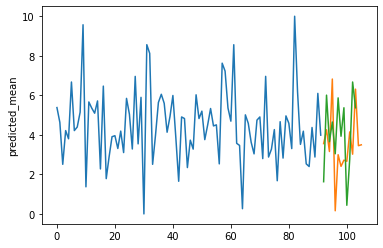

In [74]:
modelo = ARIMA(dado_treino, order=[1, 2, 60])
resultado = modelo.fit().forecast(14)
sns.lineplot(data=dado_treino)
sns.lineplot(data=resultado)
sns.lineplot(data=dado_teste)


A representação das cores do gráfico é feita da seguinte forma:
- Azul: plotagem dos dados de treino
- Verde: plotagem dos dados de teste
- Laranja: plotagem da previsão

E mais abaixo podemos verificar os dados de teste e previsão plotados juntos para melhor visualização:

<AxesSubplot:ylabel='predicted_mean'>

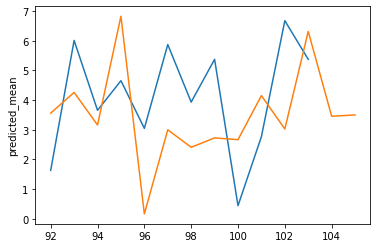

In [75]:
sns.lineplot(data=dado_teste)
sns.lineplot(data=resultado)

# Métricas

### Mean Absolute Error

In [ ]:
mae = mean_absolute_error(y_true, y_pred)

print(mae)

### Root Mean Squared Error

In [ ]:
mse = mean_squared_error(y_true, y_pred)
rmse = math.sqrt(mse)

print(rmse)